## FastAI - Model One

Using a pretrained deep learning model and the FastAI framework to train a model. Using the ResNet34 model. ResNet models at present rank fairly high in the accuracy lists, and should be a good choice for this type of probelm. 

**_NOTE! This notebook and model training was all run on SaturnCloud with GPU Augmentation, and took several hours to run. I would not recommend running this without the use of a GPU. The README.md describes how to setup on SaturnCloud to run the notebooks there._**

#### Imports & Basic Setup

In [49]:
import torch
import torchvision
import fastai
from fastai.vision.all import *

In [3]:
path = "./data"
train_path = "./data/Training Data"
val_path = "./data/Validation Data"
test_path = "./data/Testing Data"


#### Loading the Training Data

To start with, we load the training data as is - that is, with no augmentations or transformations beyond resizing. 

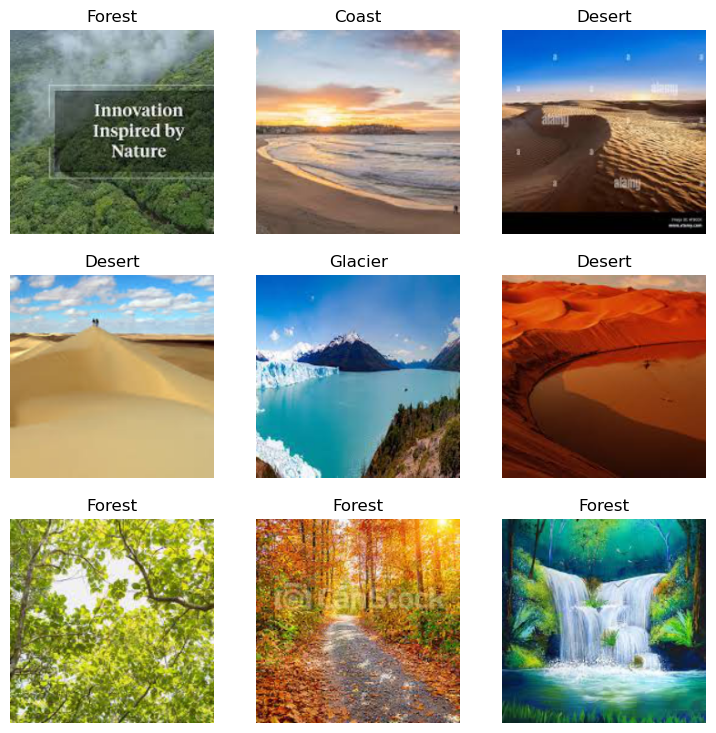

In [4]:
dataloader = ImageDataLoaders.from_folder(path, train='Training Data', valid='Validation Data', item_tfms=Resize(224))
dataloader.show_batch()

#### Model Training & Tuning

In [5]:
# Initialising the learner

learner = vision_learner(dataloader, resnet34, metrics=accuracy, path=".")

In [8]:
# Defining checkpointing methods

early_stop = EarlyStoppingCallback(patience=5)
save_best_model = SaveModelCallback(fname='best_model_resnet34')

In [9]:
# Training the model on the dataset

learner.fit_one_cycle(20, cbs=[early_stop, save_best_model])

epoch,train_loss,valid_loss,accuracy,time
0,0.766142,0.660458,0.778667,16:31
1,0.675665,0.614411,0.793333,16:36
2,0.537317,0.609276,0.808000,16:32
3,0.448206,0.571292,0.818000,16:33
4,0.379256,0.511520,0.833333,16:20
5,0.353306,0.532912,0.823333,16:25
6,0.306365,0.490975,0.845333,16:28
7,0.274053,0.537694,0.828667,16:25
8,0.264355,0.496177,0.836000,16:24
9,0.221876,0.485447,0.846000,16:24


Better model found at epoch 0 with valid_loss value: 0.6604582667350769.
Better model found at epoch 1 with valid_loss value: 0.6144112348556519.
Better model found at epoch 2 with valid_loss value: 0.6092756986618042.
Better model found at epoch 3 with valid_loss value: 0.5712921619415283.
Better model found at epoch 4 with valid_loss value: 0.5115195512771606.
Better model found at epoch 6 with valid_loss value: 0.4909752905368805.
Better model found at epoch 9 with valid_loss value: 0.48544666171073914.
No improvement since epoch 9: early stopping


(You will notice each of these epochs took an exorbitant amount of time to run - however, I suspect this was a SaturnCloud issue on that day as the following day they ran each epoch much faster. Hopefully this issue does not persist.)

In [10]:
learner.load('best_model_resnet34')

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Now that we've run a basic training pass, we will try and find a learning rate that is optimal for this model and retrain it. 

In [11]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    model.lr_find()
    
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    lrs = model.recorder.lrs
    
    return lrs[min_loss_index] / 10

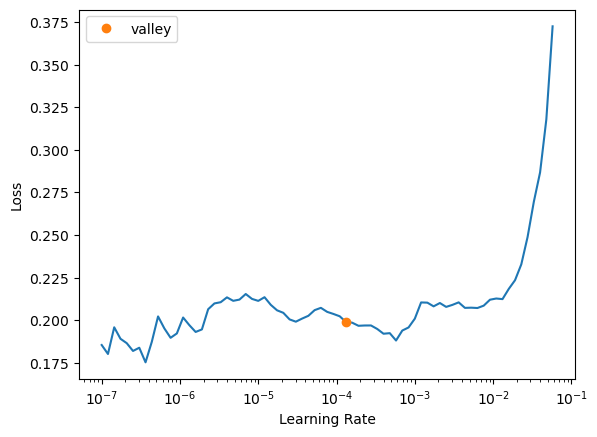

In [13]:
learning_rate = find_appropriate_lr(learner)


Before we proceed to the next training batch, though, I decide to augment the data to see if this improves the model. 

In [44]:
item_tfms = [Resize(224)]
batch_tfms = [DihedralItem(p=0.01), RandomResizedCrop(size=224, min_scale=0.06),
              Warp(magnitude=0.3), Brightness(max_lighting=0.5), Contrast(max_lighting=0.3), Saturation(max_lighting=0.3),
              Hue(max_hue=0.2), RandomErasing(p=0.3, sh=0.2, max_count=3, min_aspect=0.2)]


db = DataBlock(blocks=(ImageBlock, CategoryBlock),
               get_items=get_image_files,
               item_tfms=item_tfms,
               batch_tfms=batch_tfms, 
               get_y=parent_label)

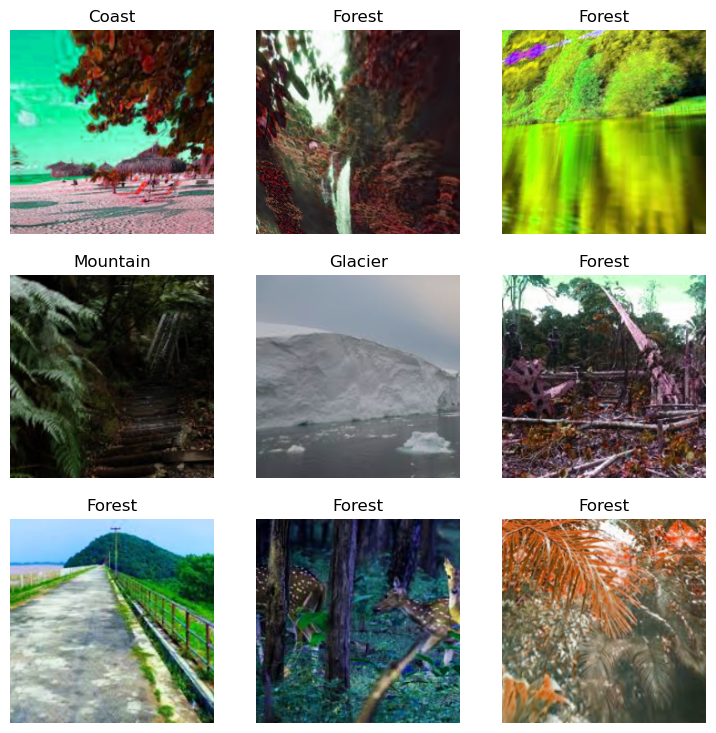

In [45]:
dataloader_aug = db.dataloaders(path)
dataloader_aug.show_batch()

As you can see, the augmented data looks quite weird to us - but hopefully the variation will improve the model! 

In [46]:
learner.dls = dataloader_aug

In [47]:
learner.fit_one_cycle(20, lr_max=slice(learning_rate/10, learning_rate), cbs=[early_stop, save_best_model])

epoch,train_loss,valid_loss,accuracy,time
0,0.769198,0.250675,0.915000,17:45
1,0.800297,0.277644,0.904583,17:50
2,0.808109,0.278377,0.904167,17:59
3,0.777006,0.247828,0.916250,18:02
4,0.826154,0.281292,0.907083,18:02
5,0.801489,0.237333,0.918750,18:03
6,0.806052,0.237995,0.919167,17:38
7,0.819495,0.260651,0.910000,17:00
8,0.790321,0.257474,0.912500,17:24
9,0.785130,0.250152,0.913333,17:04


Better model found at epoch 0 with valid_loss value: 0.250674843788147.
Better model found at epoch 3 with valid_loss value: 0.24782803654670715.
Better model found at epoch 5 with valid_loss value: 0.2373334765434265.
No improvement since epoch 5: early stopping


In [48]:
learner.load('best_model_resnet34')

At this point, the best accuracy the model had was 91%, and and the validation loss was not still 26%. Ideally, more tuning and adjusting the data augmentation should've brought up the accuracy and reduced potential overfititng. 

However, as I wanted to train a second model and I was worried each epoch would continue to take so long, I decided to export this one for now and try the second model. 

In [50]:
labels = learner.dls.vocab
labels

['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']

I opted to save the final model as an ONNX model, since this format is better for inference, and is more lightweight for deploying. Furthermore the framework makes it easy to work with models of all formats. As I was familiar with this framework, I decided to continue using it. 

As FastAI does not have built-in support for ONNX, we have to extract the base PyTorch model - which supports ONNX - and then manually add a couple of layers to the model which FastAI uses and are lacking from the Torch model.

In [52]:
pytorch_model = learner.model.eval()

softmax_layer = torch.nn.Softmax(dim=1)
normalisation_layer = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

final_model = nn.Sequential(
    normalisation_layer,
    pytorch_model,
    softmax_layer
)

In [54]:
torch.onnx.export(
    final_model,
    torch.randn(1, 3, 224, 224),
    "models/landscape_model_resnet34.onnx",
    do_constant_folding=True,
    export_params=True,
    input_names=['input'],
    output_names=['output'])

Now that this model is saved and exported, I move on to the second model I want to train. To keep notebook sizes manageable and things more organised, all of this code is in '03_model2_train.ipynb'.